# Data Preparation 
Data can be dowloaded from http://www.trialsjournal.com/content/supplementary/1745-6215-12-101-s1.csv
The article and description is at http://www.trialsjournal.com/content/12/1/101/


In [2]:
import pandas as pd


#stroke =  pd.read_csv("data/IST_data.csv", true_values='Y', false_values='N', na_values='U', skipinitialspace=True,low_memory=False)
#stroke.dropna(inplace=True,subset=['CMPLASP'])
#stroke.dropna(inplace=True,subset=['CMPLHEP'])


stroke_processed = pd.read_csv('data/stroke.csv', low_memory=False) #this mixed type warning if i dont include the low memory, why exactly?

class IST():
    def __init__(self, drug='RXHEP'):
        outcome="Alive14D"
        stroke = stroke_processed[np.isfinite(stroke_processed[outcome])]
        self.arm_id = list(stroke_processed[drug].unique())
        random.shuffle(self.arm_id) #assign random index to each arm, so bugs that prefer a index cant help
        self.arms = [stroke[stroke[drug] == arm][['actual'+drug,outcome]].values for arm in self.arm_id]
        self.arm_samples = [len(a) for a in self.arms]
    def draw_subject(self):
        r= [ random.randint(0,h) for h in self.arm_samples]
        return [(self.arm_id.index(self.arms[i][rr][0]),self.arms[i][rr][1]) for i,rr in enumerate(r)]


In [3]:
%load_ext autoreload
%autoreload 2

from multiprocessing import Pool

from IPython.display import display, HTML

from IPython.display import clear_output

from scipy import stats


import numpy as np

from numpy import random

from pymc import rbeta

import scikits.bootstrap as boot


import seaborn as sns
sns.set(style="whitegrid")
%matplotlib inline  

import math
from __future__ import division
import pprint

import numba # we need the very latest numba to do this with jit classes, TODO later
import Cython
import sys
print(sys.version_info)

np.set_printoptions(precision=3)
np.set_printoptions(suppress=True)

#from collections import deque 

sys.version_info(major=3, minor=5, micro=1, releaselevel='final', serial=0)


In [4]:
#utility functions

def ci(v):
    cie= boot.ci( v, np.mean )
    return cie[0],cie[1]

def display_results(r):
    display(r.groupby(["drug","base bandit"]).agg([ np.mean, np.median, np.min, np.max, np.std, ci]))
    display(r.groupby(["drug","high estimator"]).agg([np.mean,np.median,np.min, np.max, np.std, ci]))
    display(r.groupby(["drug","high estimator","base bandit"]).agg([ np.mean,np.median, np.min, np.max, np.std, ci]))
    display(r.groupby(["high estimator","base bandit"]).agg([ np.mean,np.median, np.min, np.max, np.std, ci]))
    sns.plt.show()

@numba.jit(nopython=True)
def sigmoid(x):
  return 1 / (1 + np.exp(-x))

@numba.jit(nopython=True)
def potentials_to_probs(x):
  return sigmoid(x)/sigmoid(x).sum()

@numba.jit(nopython=True)
def online_mean(old,v,n):
    return ((n - 1) / float(n)) * old + (1 / float(n)) * v

@numba.jit(nopython=True)
def decay_avg(old,v,n, g=0):
    return ((n - (1+g)) / float(n)) * old + ((1+g) / float(n)) * v
    # tune g online to achieve good prediction of conditional reward given chosen action

@numba.jit(nopython=True)
def stochastic_argmax(x):
    """returns the index of a max value, if there are multiple, picks one uniformly at random"""
    #  cleaner but cant numba: return np.random.choice(np.where( x >= x[x.argmax()] )[0])
    candidates = np.where( x >= x[x.argmax()] )[0]
    return ( candidates[np.random.randint(0,len(candidates))])

#much faster than np.random.choice ?
@numba.jit(nopython=True)
def categorical_draw(probs):
  z = random.random()
  cum_prob = 0.0
  for i in range(probs.shape[0]):
    cum_prob += probs[i]
    if cum_prob > z: return i
  return probs.shape[0] - 1



@numba.jit(nopython=True)
def beta(svec,fvec):
    v = np.zeros(svec.shape[0])
    for i in range(svec.shape[0]):
        v[i] = random.beta(svec[i],fvec[i])
    return v




In [5]:
class Bandit(object):
    def __init__(self, n_arms):
        self.n_arms = n_arms
        self.values = np.ones(n_arms,dtype=np.float64)
        self.counts = np.ones(n_arms, dtype=np.float64)
    def update_reward(self, chosen_arm, reward, probability=1):
        #reward= 1/probability
        self.counts[chosen_arm] += 1
        self.values[chosen_arm] = online_mean(self.values[chosen_arm],reward,self.counts[chosen_arm])


class RandomBandit(Bandit):
    def select_arm(self):
        return int(random.random()*self.n_arms)

class ThompsonBeta():
    def __init__(self, n_arms):
        self.n_arms = n_arms
        self.sucess = np.zeros(n_arms,dtype=np.float64)
        self.failures = np.zeros(n_arms, dtype=np.float64)
    def update_reward(self, chosen_arm, reward, probability=1):
        if reward == 1:self.sucess[chosen_arm] += 1/probability 
        else: self.failures[chosen_arm] += 1/probability
    def select_arm(self):
        return stochastic_argmax( beta(1 + self.sucess, 1 + self.failures) ) #uniform prior, for  jeffreys prior do 0.5 instead of 1
    def get_probs(self):
        return (1 + self.sucess )/( 2 + self.failures  + self.sucess )
    
class Softmax(Bandit):
    def select_arm(self):
        t = sum(self.counts) + 1
        temperature = 1 / math.log(t + 0.0000001) # or 0.1
        mv = np.max(self.values)
        z =  np.sum(np.exp((self.values-mv) / temperature))
        probs = np.exp((self.values-mv) / temperature) / z
        return categorical_draw(probs)

class EpsilonGreedy(Bandit):
    def select_arm(self):
        t = sum(self.counts) + 1
        epsilon = 1 / math.log(t + 0.0000001) # or jus 0.1
        if random.random() > epsilon: return stochastic_argmax(self.values)
        else: return random.randint(self.n_arms)


class UCB1(Bandit):
    def select_arm(self):
        if np.min(self.counts) == 0:
            chosen_arm = np.argmin(self.counts)
        else:
            ucb_values = np.zeros(self.n_arms)
            total_counts = np.sum(self.counts)
            for arm in range(self.n_arms):
                ucb_values[arm] = self.values[arm] + math.sqrt((2 * np.log(total_counts)) / self.counts[arm])
            chosen_arm = stochastic_argmax(ucb_values)
        return chosen_arm


class Exp3V():
    def __init__(self, n_arms):
        self.n_arms = n_arms
        self.weights = np.ones(n_arms, dtype=np.float64)
        self.probs = np.ones(n_arms, dtype=np.float64)
    def select_arm(self):
        return categorical_draw(self.probs)
    def get_probs(self):
        return self.probs
    def update_reward(self, chosen_arm, reward, probability=1):
        gamma=0.0085 #0.0085 seems to have come from the bound optimized parameters, but how?
        reward= reward/probability
        total_weight = np.sum(self.weights)
        self.weights[chosen_arm] = self.weights[chosen_arm] * np.exp((gamma) * (reward / self.probs[chosen_arm]))
        self.probs = self.weights / np.sum(self.weights)



# Build Compliance Aware Bandits and baselines

In [6]:

def make_derivative_bandits(base_algos):
    resulting_algos=[]
    for b in base_algos:
        class chosen(b):
            def update(self, chosen, actual,reward): 
                self.update_reward(chosen,reward)
        resulting_algos.append(chosen)

        class actual(b):
            def update(self, chosen, actual,reward): 
                self.update_reward(actual,reward)
        resulting_algos.append(actual)

        class comply_only(b):
            def update(self, chosen_arm, actual_arm,reward): 
                if chosen_arm == actual_arm:
                    self.update_reward( actual_arm,reward)
        resulting_algos.append(comply_only)

        class DoubleBanditRecycle():
            def __init__(self, n_arms, base_algo=b,higher_algo=Exp3V):#b
                self.n_arms = n_arms
                self.low_bandits = [base_algo(n_arms),base_algo(n_arms),base_algo(n_arms)]
                self.high_bandit = higher_algo(len(self.low_bandits)) 
                self.prev_high_chosen = []
                self.unused_samples = [[] for i in range(n_arms)]

            def update(self, chosen, actual, reward):
                if self.prev_high_chosen[0] == 0: self.low_bandits[0].update_reward(chosen,reward,self.high_bandit.get_probs()[0]) # asimptotically good no matter what
                else: self.unused_samples[chosen].append(reward)
                self.low_bandits[1].update_reward(actual,reward) # finite sample better when noncmopliance indepedent of rewards
                if chosen==actual: self.low_bandits[2].update_reward(chosen,reward)# good when noncompliers have different distribution of rewards than compliers
                self.high_bandit.update_reward(self.prev_high_chosen[0],reward)
                    
            def select_arm(self):
                choices = [self.low_bandits[i].select_arm() for i in range(len(self.low_bandits))]
                self.prev_high_chosen =[self.high_bandit.select_arm()] # [i for i, v in enumerate(choices) if v == chosen]
                if self.prev_high_chosen[0] != 0: #it is not normally when chosen would play
                    if min([len(a) for a in self.unused_samples]) > 0: #but we can still give it feedback, becuase we chose this before, so know how it woudl work out (IID)
                        reward= self.unused_samples[choices[0]].pop()
                        self.low_bandits[0].update_reward(choices[0],reward, self.high_bandit.get_probs()[0])
                return  choices[self.prev_high_chosen[0]]
        resulting_algos.append(DoubleBanditRecycle)

     
        
        class ThompsonBounded():#with recycle
            def __init__(self, n_arms, base_algo=b,higher_algo=ThompsonBeta):#b
                self.n_arms = n_arms
                self.chosen_bounding = ThompsonBeta(n_arms)
                self.low_bandits = [base_algo(n_arms)]
                self.prev_bound_used = True
                self.unused_samples = [[] for i in range(n_arms)]

            def update(self, chosen, actual, reward):
                if self.prev_bound_used:
                    self.chosen_bounding.update_reward(chosen,reward, sum(self.chosen_bounding.get_probs()**2) )
                else: 
                    self.unused_samples[chosen].append(reward)
                self.low_bandits[0].update_reward(actual,reward) # finite sample better when noncmopliance indepedent of rewards

            def select_arm(self): #aethetic of the while
                choices = [self.low_bandits[0].select_arm()]
                if (self.chosen_bounding.select_arm() == self.chosen_bounding.select_arm()):
                    bound_chose = self.chosen_bounding.select_arm()
                    if min([len(a) for a in self.unused_samples]) > 0: #but we can still give it feedback, becuase we chose this before, so know how it woudl work out (IID)
                        # use that to feed and continue since we can preserve the bound without taking away from the uncert base
                        reward= self.unused_samples[bound_chose].pop()
                        self.chosen_bounding.update_reward(bound_chose,reward, sum(self.chosen_bounding.get_probs()**2) )    
                    else:
                        self.prev_bound_used = True
                        return bound_chose #doesnt matter whic one we use, by construction, so we use 0
                self.prev_bound_used = False
                return choices[0]

   
        resulting_algos.append(ThompsonBounded)
    return resulting_algos

all_algos=make_derivative_bandits([Exp3V,EpsilonGreedy,UCB1,ThompsonBeta])
base_name = ["Exp3V", "EpsilonGreedy","UCB1","ThompsonBeta"]
high_name = ["chosen","actual","comply","HB","TB"]


# Simulation Code

In [7]:


def sim(drug, DGP=IST ,nsim=1000, T=10001, steps=10):
    columns=['base bandit','high estimator',"surplus",'drug','t']
    results = pd.DataFrame(np.zeros((nsim*steps*len(all_algos), len(columns))), columns=columns) #hardcodes 20 algos*baselines, nasty
    counter=0
    for s in range(nsim):
        dgp=DGP(drug)
        k = len(dgp.draw_subject())
        rewards=np.zeros(len(all_algos))
        bandit_instances = [b(k) for b in all_algos]
        mean_rewards = 0
        for t in range(T):
            r = dgp.draw_subject()
            mean_rewards += np.sum([v/k for a,v in r])
            for i,a in enumerate(bandit_instances): 
                chosen = int(a.select_arm())
                actual,reward = r[chosen]
                a.update(chosen,actual,reward)
                rewards[i]+= reward
            if (t%int(T/steps) == 0) and (t>0):
                for i in range(len(all_algos)):
                    results.iloc[counter] = pd.Series( {
                                        'base bandit':base_name[i//len(high_name)] , 
                                         'high estimator':high_name[i%len(high_name)],
                                         'surplus':rewards[i] - mean_rewards ,
                                         'drug':drug,
                                         't':t})
                    counter+=1
    return results



In [ ]:
inputs = ["RXASP","RXHEP"]*2 #number of replications 1/2 cores
results = pd.DataFrame(columns=['base bandit','high estimator',"surplus",'drug','t'])
with Pool(4) as p: #how many cores do we wan to use
    partial_results=(p.map(sim, inputs))
for p in partial_results:
    results = pd.concat([p,results] )
#display_results(results.loc[results['t'] == 10000].drop('t',1))
display_results(results)

#results.to_csv('simulation1.csv')

g = sns.factorplot(x='t', y="surplus", hue="high estimator", data=results,
                   size=6, palette="muted", row="base bandit") #
g.despine(left=True)
g.set_ylabels("lives saved")
g.savefig("Fig1.png")


g = sns.factorplot(x='t', y="surplus", hue="high estimator", data=results,
                   size=6, palette="muted", row="drug",col="base bandit") #
g.despine(left=True)
g.set_ylabels("lives saved")
g.savefig("by_drug_appendix.png")


In [ ]:


# g = sns.factorplot(x='t', y="surplus", hue="high estimator", data=results,
#                    size=6, palette="muted", row="base bandit") #
# g.despine(left=True)
# g.set_ylabels("lives saved")
# g.savefig("figs/Fig1.png")


g = sns.factorplot(x='t', y="surplus", hue="high estimator", data=results,
                   size=6, palette="muted", row="drug",col="base bandit") #
g.despine(left=True)
g.set_ylabels("lives saved")
g.savefig("figs/fig1.png")


In [ ]:
results.groupby(["drug","high estimator"]).agg([np.mean,np.median,np.min, np.max, np.std, ci]).to_latex()
#results.groupby(["drug","high estimator","base bandit"]).agg([ np.mean,np.median, np.min, np.max, np.std, ci])

In [ ]:


# 2(Linear regret; harmful treatment).Suppose there are two sub-populations: the first consists ofrich,
#healthy patients who always take the treatment. 
#Thesecond consists of poor,less healthy patients who only takethe treatment if prescribed. 
# Finally, suppose the treatmentreduceswellbeing by0:25on some metric.
class ExampleTwo():
    def __init__(self,foo):
        self.n_arms = 2
    def draw_subject(self):
        if random.random() > 0.5: user_type = "rich"
        else: user_type = "poor"

        if user_type == "rich":
             # if they didnt take it they would all do well, but they all take it so only 0.75 chance 
            outcome = random.binomial(1,0.75)
            r=[(1, outcome) for i in range(self.n_arms)] 
        else: #poor, they only take them if told, which brings them down from 0.5 chance to 0.75  
            reward = [random.binomial(1,0.5),random.binomial(1,0.25)] 
            r= [(i, reward[i]) for i in range(self.n_arms)]
        return r
    
example2 = sim( nsim=100, T=10001, DGP=ExampleTwo , drug="example 2")
display_results(example2.loc[example2['t'] == 10000].drop('t',1))


In [ ]:
open('tables/ex2.tex', 'w').write( example2.groupby(["high estimator","base bandit"]).agg([np.mean,np.median,np.min, np.max, np.std, ci]).to_latex() )


In [ ]:


g = sns.factorplot(x='t', y="surplus", hue="high estimator", data=example2,
                   size=6, palette="muted", col="base bandit") #
g.despine(left=True)
g.set_ylabels("lives saved")
g.savefig("figs/ex2.png")


In [22]:
class NoncomplianceForBestArm():
    def __init__(self,foo ):
        n_arms=10
        self.arm_value = np.zeros(n_arms)+0.25 #np.random.random(n_arms)#0.5+0.25*
        self.arm_value[np.random.randint(n_arms)] = 0.75
        self.n_arms = n_arms
    def draw_subject(self):
        prefered_arm = stochastic_argmax(self.arm_value)
        prefered_reward = random.binomial(1,self.arm_value[prefered_arm])
        r = []
        for i in range(self.n_arms):
            if 0.5 < random.random(): #informative noncompliance, could be proportional to loss self.arm_value[i] / self.arm_value[prefered_arm]
                r.append((prefered_arm,prefered_reward))
            else:  #compliers 
                r.append((i,  random.binomial(1,self.arm_value[i])))
        return r

example3= sim( nsim=100, T=101, DGP=NoncomplianceForBestArm , drug="Better arm")
#display_results(example3.loc[example3['t'] == 10000].drop('t',1))


/Users/nikete/anaconda/envs/3.5/lib/python3.5/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


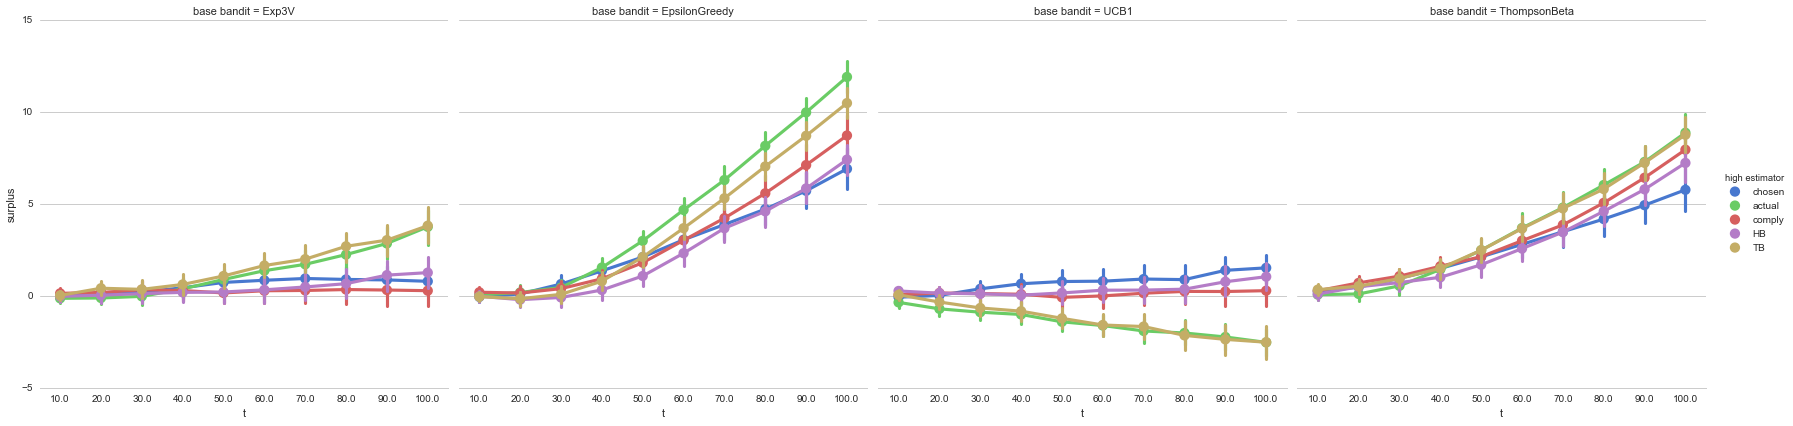

In [23]:

g = sns.factorplot(x='t', y="surplus", hue="high estimator", data=example3,
                   size=6, palette="muted", col="base bandit") #
g.despine(left=True)
g.savefig("figs/ex3.png")


In [ ]:
open('tables/ex3.tex', 'w').write( example3.groupby(["high estimator","base bandit"]).agg([np.mean,np.median,np.min, np.max, np.std, ci]).to_latex() )


In [10]:
#always or never takers. current simulation model is not rich enough for defiers, todo?
class IndependentNoncomplianceAndRewards():
    def __init__(self,foo):
        n_arms=2
        self.arm_value = 0.9+0.1*np.random.random(int(n_arms))
        # todo add effect_magnitude=1
        self.n_arms = n_arms
    def draw_subject(self):
        if random.random()<0.9: #compliers 
            r=[(i, random.binomial(1,self.arm_value[i])) for i in range(self.n_arms)]
        else:   #always takers
            actual = categorical_draw(self.arm_value)
            reward = random.binomial(1,self.arm_value[actual])
            r= [(actual, reward) for i in range(self.n_arms)]
        return r

    
example4= sim( nsim=100, T=10001, DGP=IndependentNoncomplianceAndRewards , drug="example")
#display_results(example4.loc[example4['t'] == 10000].drop('t',1))



/Users/nikete/anaconda/envs/3.5/lib/python3.5/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


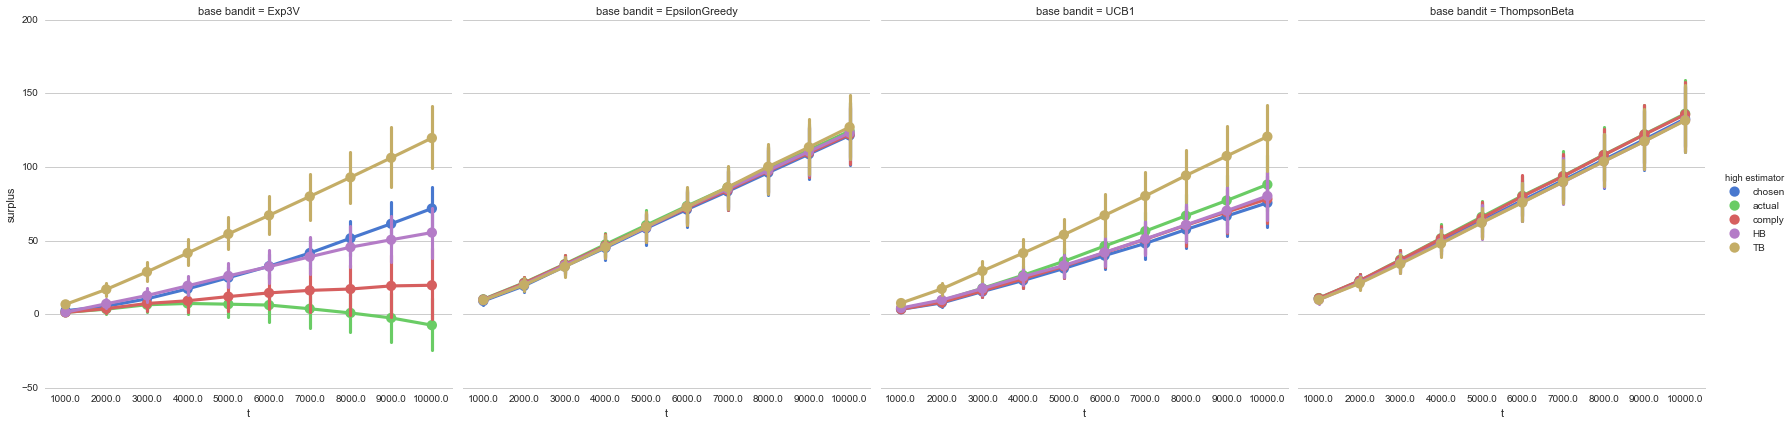

In [ ]:
g = sns.factorplot(x='t', y="surplus", hue="high estimator", data=example4,
                   size=6, palette="muted", col="base bandit") #
g.despine(left=True)
g.savefig("figs/ex4.png")


In [ ]:
#REMEMBER TO SET EXP3V appropiately before running this (TODO: document how the exp3 constant is set!)

class IndependentNoncomplianceAndRewards():
    def __init__(self,foo):
        n_arms=2
        self.arm_value = np.random.random(int(n_arms))
        # todo add effect_magnitude=1
        self.n_arms = n_arms
    def draw_subject(self):
        if random.random()>0.5: #compliers 
            r=[(i, random.binomial(1,self.arm_value[i])) for i in range(self.n_arms)]
        else:   #always takers
            actual = categorical_draw(self.arm_value)
            reward = random.binomial(1,self.arm_value[actual])
            r= [(actual, reward) for i in range(self.n_arms)]
        return r


    
example5= sim( nsim=1000, T=12, DGP=IndependentNoncomplianceAndRewards , drug="example")
display_results(example5.loc[example5['t'] == 11].drop('t',1))




In [ ]:
g = sns.factorplot(x='t', y="surplus", hue="high estimator", data=example5,
                   size=6, palette="muted", col="base bandit") #
g.despine(left=True)